# Creating Imide-Ammonia Cif:

In [1]:
import array as arr
import numpy as np
from mayavi import mlab
from numpy import pi, cos, sin, arccos, arange

def plot_axes(n, c=(0., 0., 0.)):    
    # n is number of axes wanted, c describes colour of axes
    o = np.zeros(2)
    a = np.array([0., n])
    mlab.plot3d(a, o, o, tube_radius=None, color=c)
    mlab.plot3d(o, a, o, tube_radius=None, color=c)
    mlab.plot3d(o, o, a, tube_radius=None, color=c)
    return

def spherical_grid(n=500):
    # n is the number of points created on the spherical grid
    indices = arange(0, n, dtype=float) + 0.5
    phi = arccos(1 - 2*indices/n)
    theta = pi * (1 + 5**0.5) * indices
    x, y, z = cos(theta) * sin(phi), sin(theta) * sin(phi), cos(phi)
    return x, y, z

def get_incl(x, y, z):
    # Gives inclination angle given cartesian coordinates x, y, z
    xyd = np.sqrt((x**2) + (y**2))
    return np.arctan2(xyd, z) 

def get_az(x, y):
    # Gives azimuth angle given cartesian coordinates x, y 
    az = np.arctan2(y, x)
    az[az < 0] += 2*np.pi
    return az

def polar_to_cart_elev(r, elev, az):
    # converts polar coordinates r, elev, az into cartesian coordinates x, y, z
    x = r * np.cos(elev) * np.cos(az)
    y = r * np.cos(elev) * np.sin(az)
    z = r * np.sin(elev)
    return x, y, z

In [2]:
data = np.loadtxt('force_map_data_basis.csv', skiprows=1, dtype='float', delimiter=',', usecols=(0, 1, 2, 3), unpack=True)
data = data.T

- Column 0 is x 
- Column 1 is y 
- Column 2 is z
- Column 3 is force value 

## Imide Prediction

In [3]:
# taking lowest 1 % of 10,000 values
n = int(10000 / 100)
min_is = np.argpartition(data[:,3], n-1)[:n]
x_min = data[:,0][min_is]
y_min = data[:,1][min_is]
z_min = data[:,2][min_is]

In [4]:
# visualising the lowest 1% of force potential positions
mlab.figure(bgcolor=(1., 1., 1.))
mlab.points3d(data[:,0], data[:,1], data[:,2], data[:,3], scale_factor=0.1, scale_mode='none', colormap='viridis')
mlab.points3d(x_min, y_min, z_min, color=(1., 0., 0.), scale_factor=0.1, opacity=1)
plot_axes(1.5)
mlab.orientation_axes()
#mlab.show()

In [5]:
min_imide_index = np.argmin(data[:,3])
x_m = data[:,0][min_imide_index]
y_m = data[:,1][min_imide_index]
z_m = data[:,2][min_imide_index]

In [6]:
# visualising force potential minimimum
mlab.figure(bgcolor=(1., 1., 1.))
mlab.points3d(data[:,0], data[:,1], data[:,2], data[:,3], scale_factor=0.1, scale_mode='none', colormap='viridis')
mlab.points3d(x_m, y_m, z_m, color=(1., 0., 0.), scale_factor=0.1, opacity=1)
plot_axes(1.5)
mlab.orientation_axes()
#mlab.show()

## Ammonia Modelling

In [7]:
def get_ammonia_points(elev, az, n, psi, r=1):                   
    #generate n random points at angle psi from the north pole (0,0,1)
    e = np.pi/2 - elev
    a = -(az + np.pi)
    rdm = np.random.rand()
    new_az = np.linspace(rdm, (rdm + 1), n) * 2 * np.pi
    new_elev = (np.pi / 2. - psi * np.pi / 180.) * np.ones(n)
    #find cartesian coordinates of these
    x, y, z = polar_to_cart_elev(r, new_elev, new_az)
    #now rotate points (by putting north pole back to point elev, az:
    sin, cos = np.sin, np.cos
    xp = cos(e)*cos(a)*x + sin(a)*y - sin(e)*cos(a)*z
    yp = -sin(a)*cos(e)*x + cos(a)*y + sin(a)*sin(e)*z
    zp = sin(e)*x + cos(e)*z
    #generating random points at angle psi from point provided and the ones produced
    az_3 = new_az + (psi * np.pi / 180.)
    x3, y3, z3 = polar_to_cart_elev(r, new_elev, az_3)
    sin, cos = np.sin, np.cos
    xp3 = cos(e)*cos(a)*x3 + sin(a)*y3 - sin(e)*cos(a)*z3
    yp3 = -sin(a)*cos(e)*x3 + cos(a)*y3 + sin(a)*sin(e)*z3
    zp3 = sin(e)*x3 + cos(e)*z3
    # returns ____
    return xp, yp, zp, xp3, yp3, zp3

x, y, z = spherical_grid(n=100)

pt_elev = np.pi / 2. - get_incl(x, y, z)
pt_az = get_az(x, y)
pt_incl = get_incl(x, y, z)

In [8]:
def plot_each_ammonia(n, a, ammonia_angle):                                           
    # a = index of point on spherical grid
    xp, yp, zp, xp3, yp3, zp3 = get_ammonia_points(pt_elev[a], pt_az[a], n, ammonia_angle)    # AMIDE ANGLE SPECIFIED HERE
    x0, y0, z0 = polar_to_cart_elev(1, pt_elev[a], pt_az[a])

    mlab.figure(bgcolor=(1., 1., 1.))
    mlab.points3d(x, y, z, scale_factor=0.1, scale_mode='none')
    mlab.points3d(x0, y0, z0, color=(1., 0., 0.), scale_factor=0.1)
    mlab.points3d(xp, yp, zp, color=(0., 0., 1.), scale_factor=0.1)
    mlab.points3d(xp3, yp3, zp3, color=(0., 1., 0.), scale_factor=0.1)
    plot_axes(1.5)
    mlab.orientation_axes()
    mlab.show()
    
plot_each_ammonia(6, 1, 107.8)  # n = 6 is very tidy

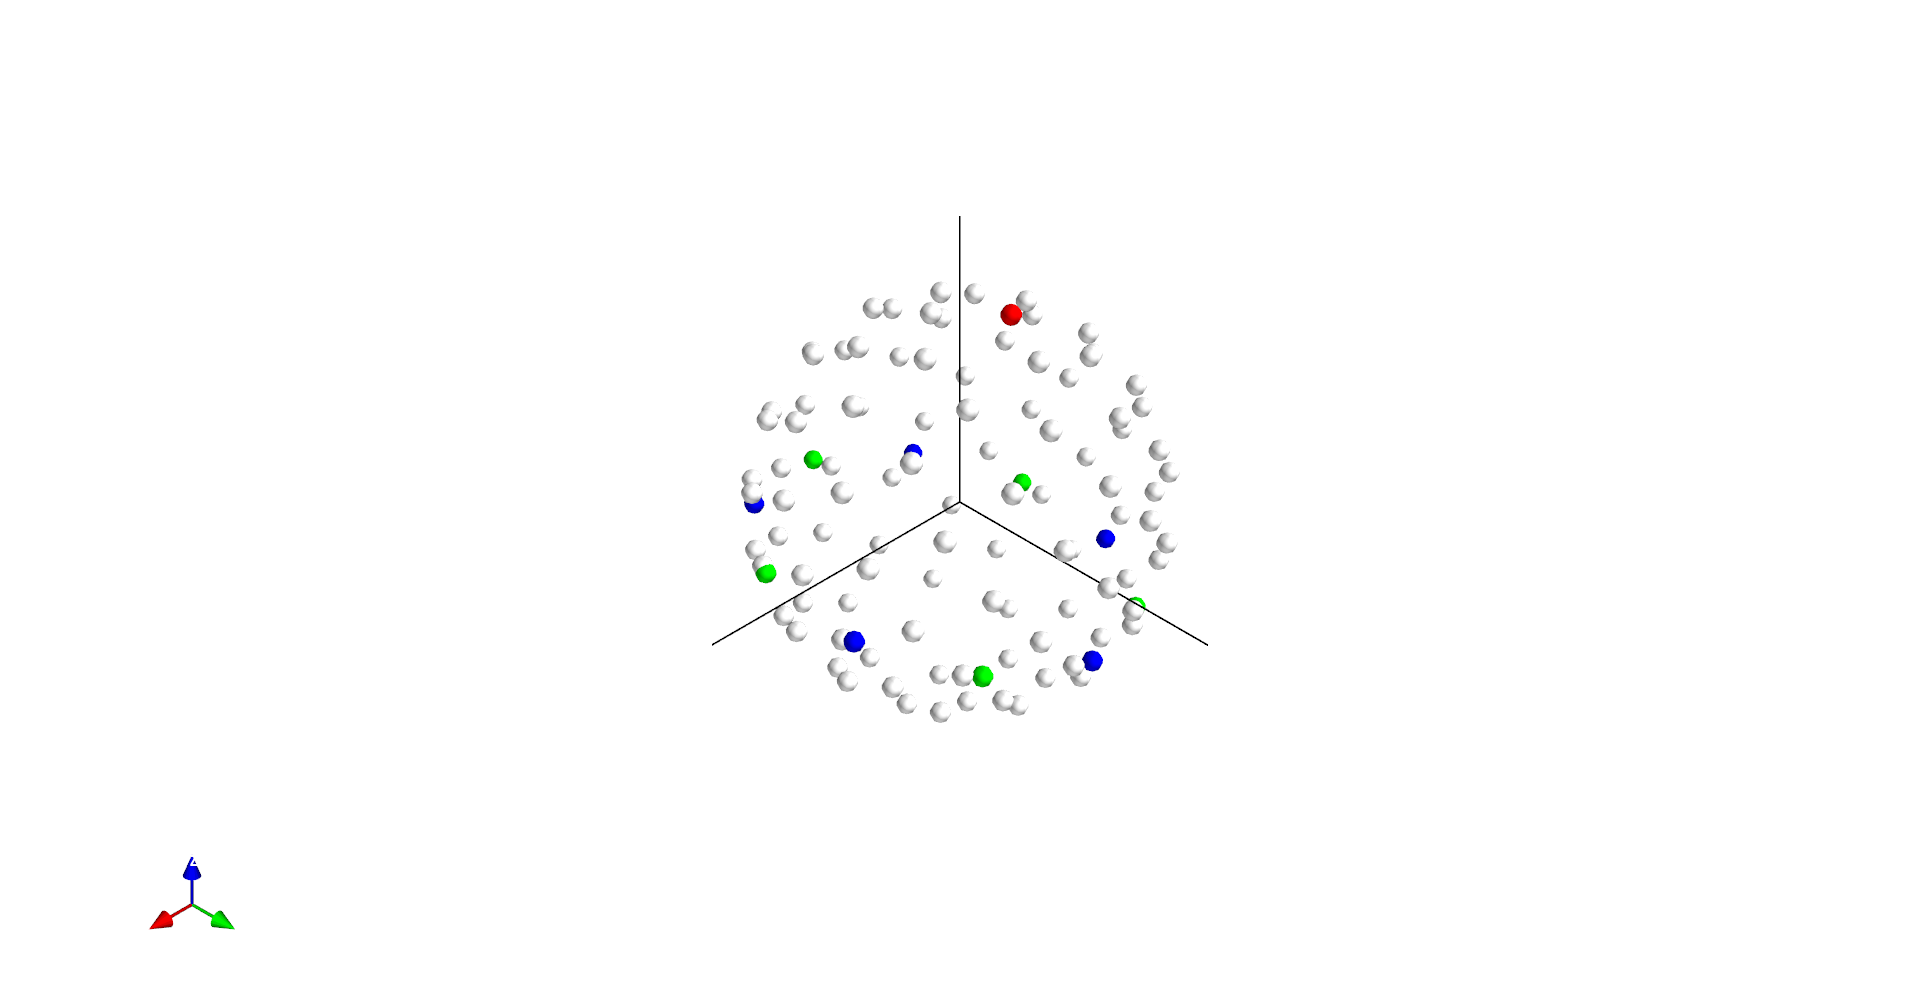

In [9]:
def iterate(n_grid=10000, n_circ=6, ammonia_angle=107.8):
    # returns arrays of the x,y,z coordinates of the three ammonium hydrogen positions at ammonia_angle from each other
    x1 = arr.array('f', [])
    y1 = arr.array('f', [])
    z1 = arr.array('f', [])
    x2 = arr.array('f', [])
    y2 = arr.array('f', [])
    z2 = arr.array('f', [])
    x3 = arr.array('f', [])
    y3 = arr.array('f', [])
    z3 = arr.array('f', [])
    
    x, y, z = spherical_grid(n_grid)
    pt_elev = np.pi / 2. - get_incl(x, y, z)
    pt_az = get_az(x, y)
    pt_incl = get_incl(x, y, z)
    for i in range(len(x)):
        xp, yp, zp, xp3, yp3, zp3 = get_ammonia_points(pt_elev[i], pt_az[i], n_circ, ammonia_angle, r=1.017)
        x0, y0, z0 = polar_to_cart_elev(1.017, pt_elev[i], pt_az[i])                 # r in angstrom

        x3.extend(xp3[0:5])
        y3.extend(yp3[0:5])
        z3.extend(zp3[0:5])
        x2.extend(xp[0:5])
        y2.extend(yp[0:5])
        z2.extend(zp[0:5])
        x1.extend([x0 for a in range(5)])
        y1.extend([y0 for a in range(5)])
        z1.extend([z0 for a in range(5)])
        
    return x1, y1, z1, x2, y2, z2, x3, y3, z3

In [10]:
x1, y1, z1, x2, y2, z2, x3, y3, z3 = iterate(n_grid=100, n_circ=6, ammonia_angle=107.8)

In [11]:
# visual check
mlab.figure(bgcolor=(1., 1., 1.))
mlab.points3d(x1[7], y1[7], z1[7], scale_factor=0.1, scale_mode='none')
mlab.points3d(x2[5:10], y2[5:10], z2[5:10], color=(1., 0., 0.), scale_factor=0.1)
mlab.points3d(x3[5:10], y3[5:10], z3[5:10], color=(0., 1., 0.), scale_factor=0.1)
plot_axes(1.5)
mlab.orientation_axes()
#mlab.show()

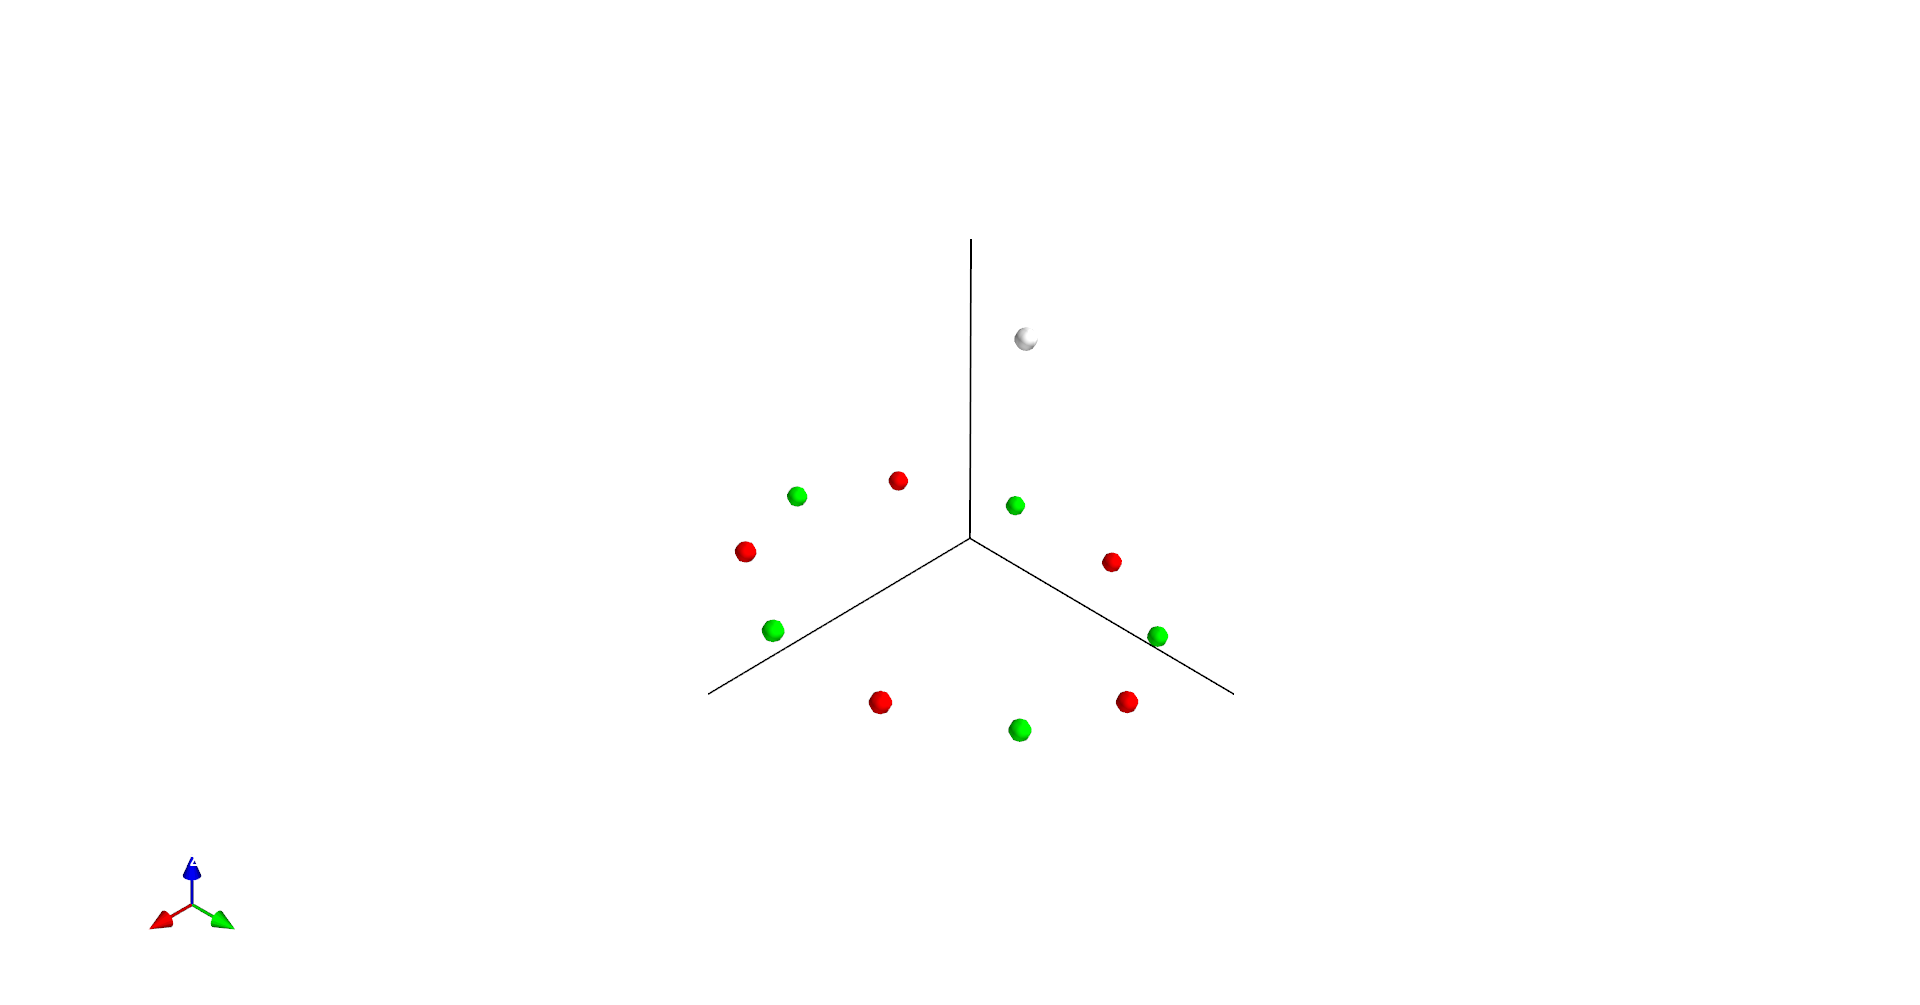

## Ammonia Prediction

In [12]:
%run -i Force_Heat_Maps.ipynb

Minimum energy cif: 1
Maximum energy cif: 700
[1. 1. 1. ... 1. 1. 1.]


In [13]:
def ammonia_forces(n_grid=10000, n_circ=6, ammonia_angle=107.8):
    # returns 3 arrays of each ammonia hydrogen's coordinate set and that orientations total force potential
    x1, y1, z1, x2, y2, z2, x3, y3, z3 = iterate(n_grid, n_circ, ammonia_angle)
    pts1 = np.column_stack((x1, y1, z1))
    pts2 = np.column_stack((x2, y2, z2))
    pts3 = np.column_stack((x3, y3, z3))
    f1 = find_approx_forces(known_pts, pts1, f_t)
    f2 = find_approx_forces(known_pts, pts2, f_t)
    f3 = find_approx_forces(known_pts, pts3, f_t)
    
    ftot = f1 + f2 + f3

    return pts1, pts2, pts3, ftot

In [14]:
pts1, pts2, pts3, ftot = ammonia_forces()

In [15]:
# taking lowest 1% of 50,000 values
n = int(50000 / 500)
min_is_ammonia = np.argpartition(ftot, n-1)[:n]
pts1_min = pts1[min_is_ammonia]
pts2_min = pts2[min_is_ammonia]
pts3_min = pts3[min_is_ammonia]

pts1_minT = pts1_min.T
pts2_minT = pts2_min.T
pts3_minT = pts3_min.T

In [16]:
min_ammonia_index = np.argmin(ftot)
h1_am = pts1[min_ammonia_index]
h2_am = pts2[min_ammonia_index]
h3_am = pts3[min_ammonia_index]

In [17]:
# visualising lowest 1% of force potentials of all orientations and minimum orientation
mlab.figure(bgcolor=(1., 1., 1.))
mlab.points3d(grid[0], grid[1], grid[2], fc, scale_factor=0.1, scale_mode='none', colormap='viridis')
mlab.points3d(pts1_minT[0], pts1_minT[1], pts1_minT[2], color=(0.2, 0.2, 0.2), scale_factor=0.1, opacity=1)
mlab.points3d(pts2_minT[0], pts2_minT[1], pts2_minT[2], color=(0.2, 0.2, 0.2), scale_factor=0.1, opacity=1)
mlab.points3d(pts3_minT[0], pts3_minT[1], pts3_minT[2], color=(0.2, 0.2, 0.2), scale_factor=0.1, opacity=1)
mlab.points3d(h1_am[0], h1_am[1], h1_am[2], color=(1., 0., 0.), scale_factor=0.1, opacity=1)
mlab.points3d(h2_am[0], h2_am[1], h2_am[2], color=(1., 0., 0.), scale_factor=0.1, opacity=1)
mlab.points3d(h3_am[0], h3_am[1], h3_am[2], color=(1., 0., 0.), scale_factor=0.1, opacity=1)
plot_axes(1.5)
mlab.orientation_axes()
#mlab.show()

## Cif Creation

In [18]:
from pymatgen.io.cif import CifParser, CifWriter
fname = 'C:\\Users\\Path\\NaNH2.cif'
cif = CifParser(fname)

In [19]:
structure = cif.get_structures()[0]

In [20]:
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
rstructure = SpacegroupAnalyzer(structure).get_refined_structure()

In [21]:
def rstruc_coords(number_Na=16, number_H=32, number_N=16):
    Na_x = arr.array('f', [])
    H_x = arr.array('f', [])
    N_x = arr.array('f', [])
    
    Na_y = arr.array('f', [])
    H_y = arr.array('f', [])
    N_y = arr.array('f', [])
    
    Na_z = arr.array('f', [])
    H_z = arr.array('f', [])
    N_z = arr.array('f', [])
    
    for i in range(0, number_Na):
        Na_x.append(rstructure.sites[i].coords[0])
    for j in range(number_Na, (number_Na+number_H+1)):
        H_x.append(rstructure.sites[j].coords[0])
    for k in range((number_Na+number_H+1), (number_Na+number_H+number_N)):
        N_x.append(rstructure.sites[k].coords[0])
        
    for i in range(0, number_Na):
        Na_y.append(rstructure.sites[i].coords[1])
    for j in range(number_Na, (number_Na+number_H+1)):
        H_y.append(rstructure.sites[j].coords[1])
    for k in range((number_Na+number_H+1), (number_Na+number_H+number_N)):
        N_y.append(rstructure.sites[k].coords[1])
        
    for i in range(0, number_Na):
        Na_z.append(rstructure.sites[i].coords[2])
    for j in range(number_Na, (number_Na+number_H+1)):
        H_z.append(rstructure.sites[j].coords[2])
    for k in range((number_Na+number_H+1), (number_Na+number_H+number_N)):
        N_z.append(rstructure.sites[k].coords[2])
        
    return Na_x, H_x, N_x, Na_y, H_y, N_y, Na_z, H_z, N_z
        
Na_x, H_x, N_x, Na_y, H_y, N_y, Na_z, H_z, N_z = rstruc_coords()

In [22]:
# select amides you wish to convert 
# rotate the ammonia/imide configuration to correct orientation within cif
# add to imide/ammonia centre (the coordinates of the nitrogen in the amides being converted)
# move hydrogen to new site

In [23]:
imide_centre = np.array([1.9336, 0.0000, 5.2348])
ammonia_centre = np.array([0.1524, 2.2513, 7.8522])

new_struc = rstructure.copy()
new_struc.sites[0].coords = [(imide_centre[0] + x_m),(imide_centre[1] + y_m),(imide_centre[2] + z_m)]
new_struc.sites[1].coords = [(ammonia_centre[0] + h1_am[0]),(ammonia_centre[1] + h1_am[1]),(ammonia_centre[2] + h1_am[2])]
new_struc.sites[2].coords = [(ammonia_centre[0] + h2_am[0]),(ammonia_centre[1] + h2_am[1]),(ammonia_centre[2] + h2_am[2])]
new_struc.sites[3].coords = [(ammonia_centre[0] + h3_am[0]),(ammonia_centre[1] + h3_am[1]),(ammonia_centre[2] + h3_am[2])]
    
w = CifWriter(new_struc)
file = 'C:\\Users\\Path\\New.cif'
w.write_file(file)